# Simple Benchmark on $loss(x) = \|I - x^T x\|^2$ with and without `adaptive=True`

## Prepare environment

### Install required packages


In [1]:
# Uninstall optax and reinstall just to be sure we're using the latest version
!pip uninstall -q optax -y && pip install -q git+https://github.com/leloykun/optax.git@fc--add-muon
# !pip uninstall -q optax -y && pip install -q -e ~/optax
# Install plotting libraries
!pip install -q matplotlib seaborn

You can comment out the cell above after running it at least once.

### Import required packages

In [1]:
from functools import partial
from typing import Union, Tuple

import jax
import jax.numpy as jnp
import optax
from optax.contrib import muon

import matplotlib.pyplot as plt
import seaborn as sns

## Benchmark

### Utils

In [2]:
def loss(x: jnp.ndarray, n: int):
    return jnp.linalg.norm(jnp.eye(n) - x.T @ x)**2

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss), static_argnames=("n",))

In [3]:
@partial(jax.jit, static_argnames=("n", "num_iterations", "learning_rate", "newton_schulz_coeffs", "newton_schulz_steps", "beta", "adaptive"))
def train(
    x: jnp.ndarray,
    n: int = 2,
    num_iterations: int = 100,
    learning_rate: float = 0.001,
    newton_schulz_coeffs: Union[
      Tuple[float, float, float],
      Tuple[Tuple[float, float, float], ...],
    ] = (3.4445, -4.7750, 2.0315),
    newton_schulz_steps: int = 5,
    beta: float = 0.95,
    adaptive: bool = False,
):
    optimizer = optax.chain(
        muon(
            learning_rate=learning_rate,
            newton_schulz_coeffs=newton_schulz_coeffs,
            newton_schulz_steps=newton_schulz_steps,
            beta=beta,
            adaptive=adaptive,
            mu_dtype=x.dtype,
        )
    )
    opt_state = optimizer.init(x)

    def body_fn(values: tuple[jnp.ndarray, optax.OptState], _):
        x, opt_state = values
        loss, grad = loss_and_grad_fn(x, n)
        updates, opt_state = optimizer.update(grad, opt_state)
        new_x = optax.apply_updates(x, updates)
        return (new_x, opt_state), loss

    _, losses = jax.lax.scan(body_fn, (x, opt_state), length=num_iterations)

    return losses

batch_train = jax.vmap(train, in_axes=(0, None, None, None, None, None, None, None))

### Benchmark body

In [4]:
def benchmark_muon_variants(
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    num_iterations: int=100,
    learning_rate: float=0.1,
    newton_schulz_steps: int=5,
    beta: float=0.0,
    savefile: str="images/muon_variants.png",
):
    key = jax.random.PRNGKey(0)
    X = jax.random.uniform(key, shape=(b, n, n), dtype=dtype)

    results = {}
    for optimize_coeffs in [False, True]:
        for adaptive in [False, True]:
            newton_schulz_coeffs = (
                (3.4445, -4.7750, 2.0315)
                if not optimize_coeffs
                else (
                    (2.9145, -4.3663, 2.4515),
                    (2.9131, -4.3582, 2.4446),
                    (2.9030, -4.3145, 2.4106),
                    (2.8317, -4.0251, 2.1928),
                    (2.8392, -3.3535, 1.5149),
                )
            )
            losses = batch_train(
                X,
                n,
                num_iterations,
                learning_rate,
                newton_schulz_coeffs,
                newton_schulz_steps,
                beta,
                adaptive,
            )
            results[(optimize_coeffs, adaptive)] = losses

    palette = sns.color_palette(n_colors=4)
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, ((optimized, adaptive), all_losses) in enumerate(results.items()):
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            median_losses,
            label=f"Muon{'; adaptive' if adaptive else '          '}{'; optimized coeffs' if optimized else ''}",
            linestyle="--" if optimized else "-",
            color=palette[idx],
            linewidth=2.5,
        )
        for losses in all_losses:
            sns.lineplot(
                losses,
                alpha=0.02,
                color=palette[idx],
            )
    plt.title(f"Muon Variants (beta={beta:.3f}, lr={learning_rate}, dtype={dtype.dtype})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

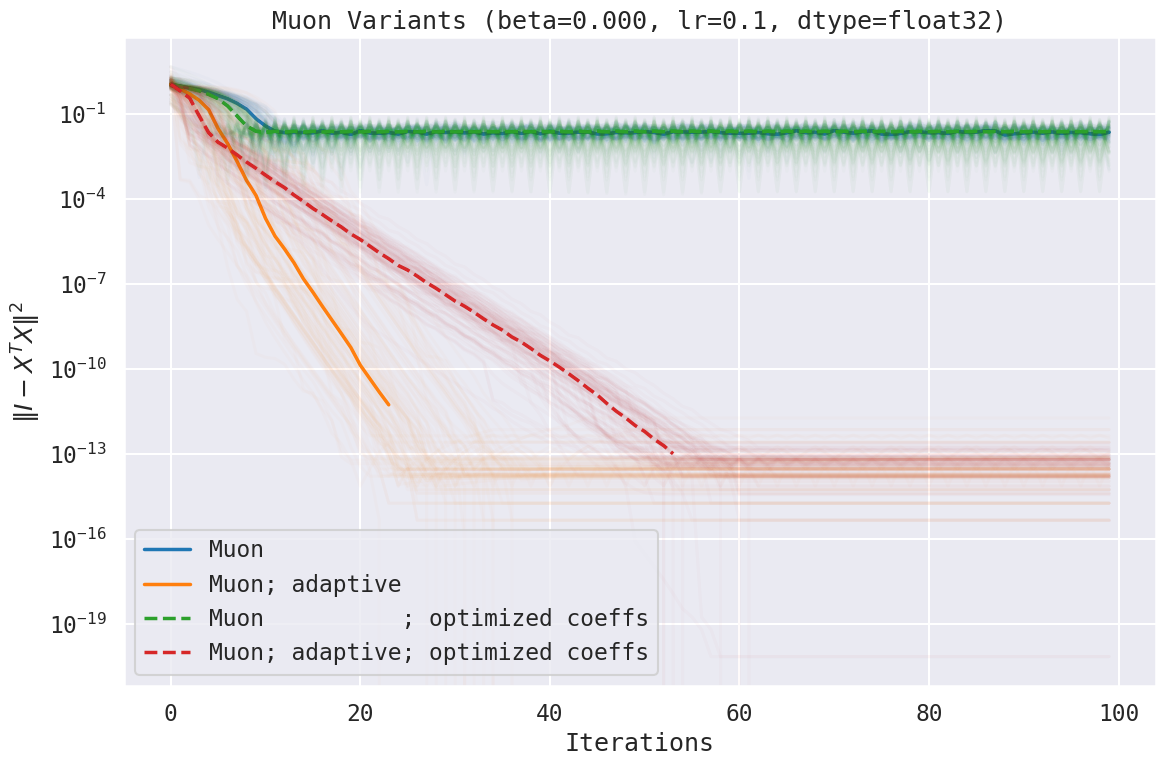

In [5]:
benchmark_muon_variants(
    num_iterations=100,
    learning_rate=0.1,
    beta=0.0,
)

In [6]:
def benchmark_muon_by_momentum_decay(
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    adaptive: bool=False,
    num_iterations: int=100,
    learning_rate: float=0.1,
    newton_schulz_steps: int=5,
    optimize_coeffs: bool=False,
    savefile: str="images/adaptive_muon_by_momentum_decay.png",
):
    key = jax.random.PRNGKey(0)
    X = jax.random.uniform(key, shape=(b, n, n), dtype=dtype)

    betas = jnp.linspace(0, 0.999, 10).tolist()
    betas.insert(-1, 0.95)

    newton_schulz_coeffs=(
        (3.4445, -4.7750, 2.0315)
        if not optimize_coeffs
        else (
            (2.9145, -4.3663, 2.4515),
            (2.9131, -4.3582, 2.4446),
            (2.9030, -4.3145, 2.4106),
            (2.8317, -4.0251, 2.1928),
            (2.8392, -3.3535, 1.5149),
        )
    )

    results = {}
    for beta in betas:
        losses = batch_train(
            X,
            n,
            num_iterations,
            learning_rate,
            newton_schulz_coeffs,
            newton_schulz_steps,
            beta,
            adaptive,
        )
        results[beta] = losses

    palette = sns.color_palette("crest", len(betas))
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, (beta, all_losses) in enumerate(results.items()):
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            median_losses,
            label=f"$\\beta$={beta:.3f}{'**' if beta == 0.95 else ''}",
            color=palette[idx],
            linewidth=2.5,
        )
        for losses in all_losses:
            sns.lineplot(
                losses,
                alpha=0.02,
                color=palette[idx],
            )
    plt.title(f"{'Adaptive ' if adaptive else ''}Muon: Limitation of Momentum (lr={learning_rate}, dtype={dtype.dtype})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    plt.yscale("log")
    plt.legend(title=f"$\\beta$ Values", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

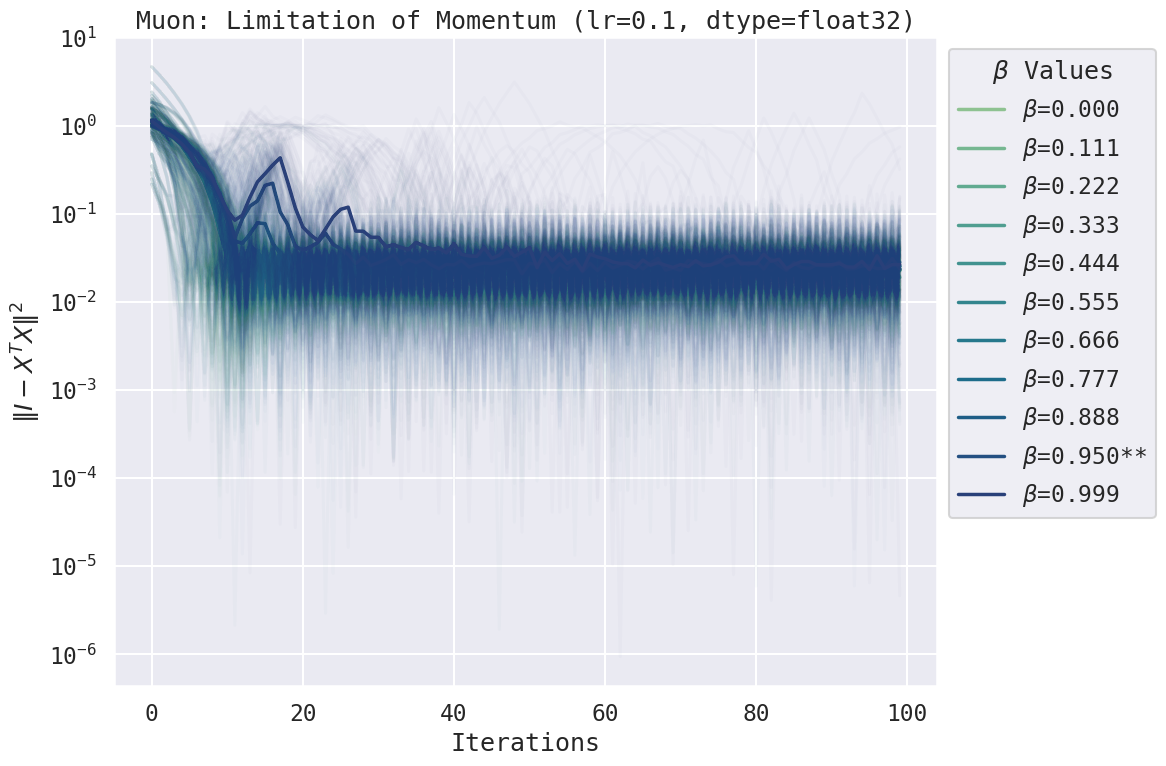

In [7]:
benchmark_muon_by_momentum_decay(
    adaptive=False,
    optimize_coeffs=False,
    savefile="images/muon_by_momentum_decay_optimized_coeffs.png",
)

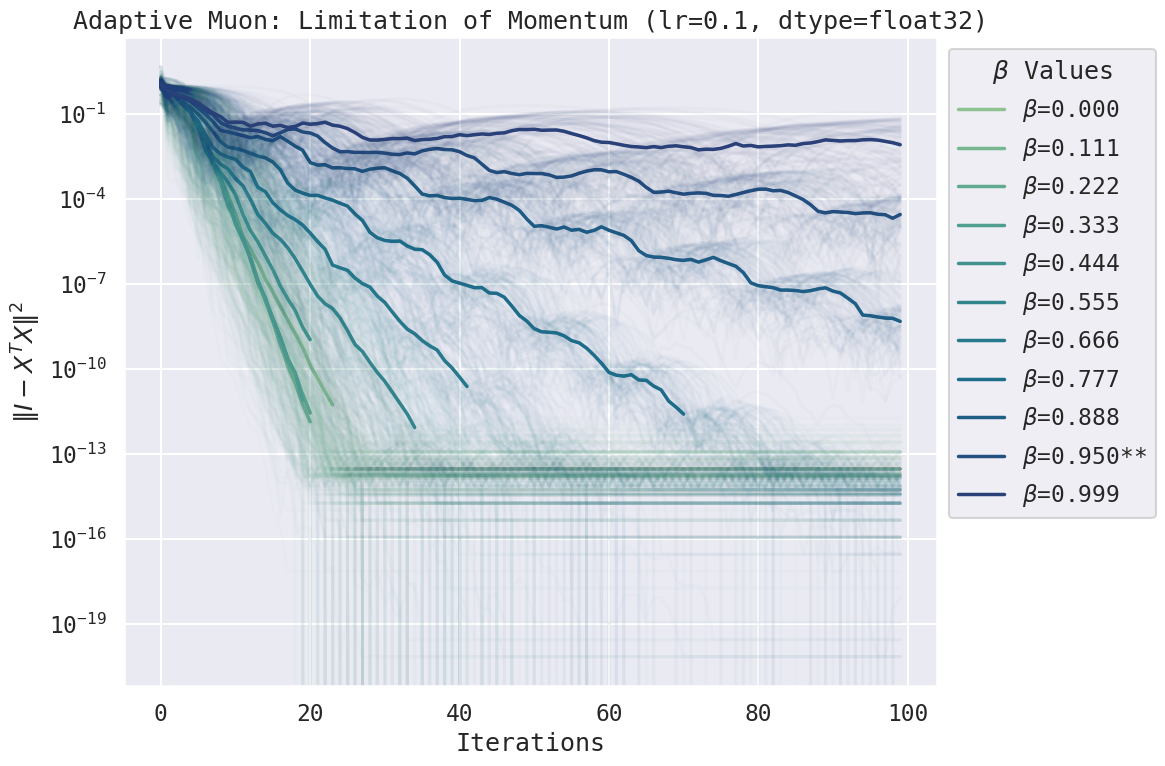

In [8]:
benchmark_muon_by_momentum_decay(
    adaptive=True,
    optimize_coeffs=False,
)

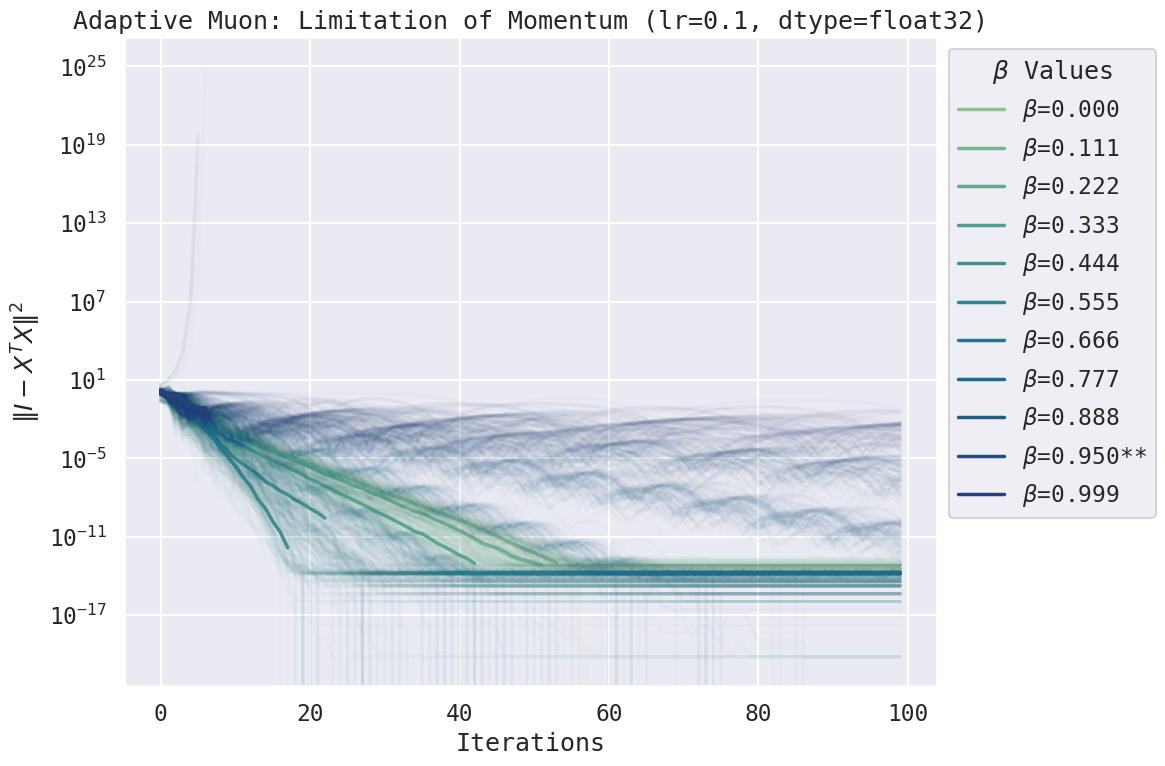

In [9]:
benchmark_muon_by_momentum_decay(
    adaptive=True,
    optimize_coeffs=True,
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt.png",
)

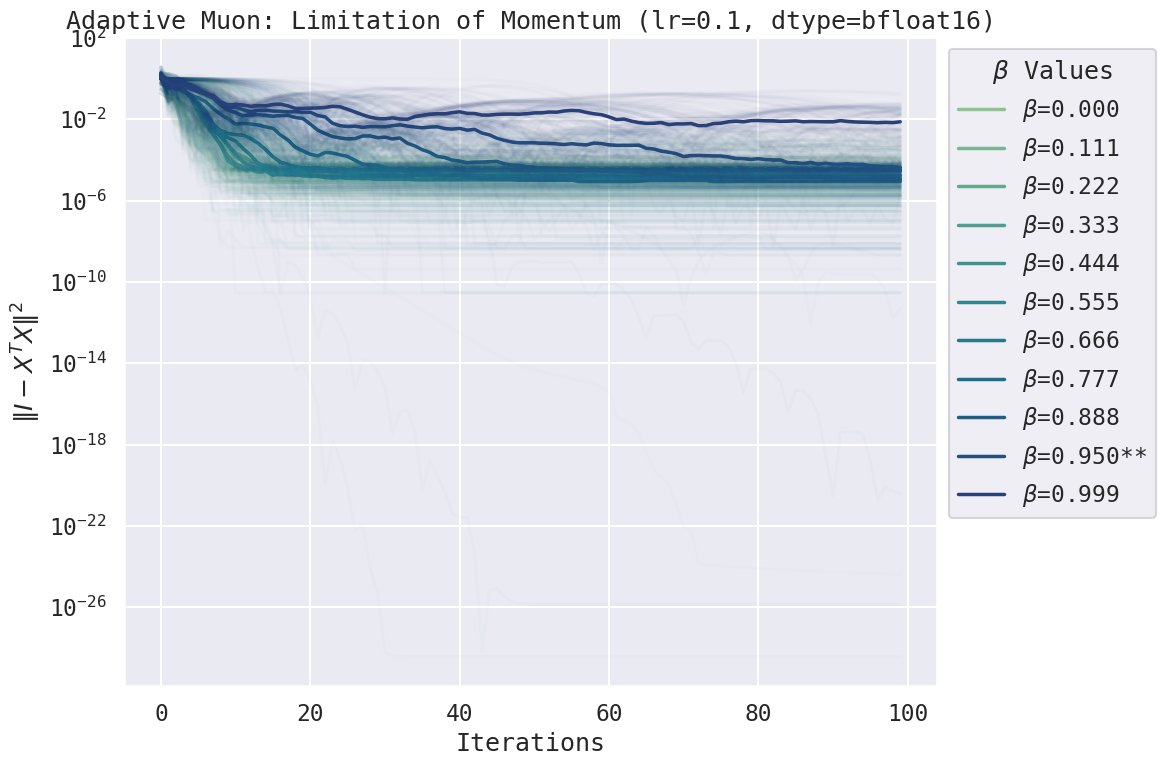

In [10]:
benchmark_muon_by_momentum_decay(
    adaptive=True,
    optimize_coeffs=False,
    dtype=jnp.bfloat16,
    savefile="images/adaptive_muon_by_momentum_decay_bfloat16.png",
)